# Word2Vec training

This notebook is based on the [word2vec-pytorch](https://github.com/OlgaChernytska/word2vec-pytorch/tree/18d4f24c4d82dde76de9f6e4d88bbcbcf68befc2) repo.

In [ ]:
!python -m wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!python -m unzip wikitext-2-v1.zip

In [12]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [2]:
TRAIN_TOKENS = 'wikitext-2/wiki.train.tokens'
VALID_TOKENS = 'wikitext-2/wiki.valid.tokens'

SKIPGRAM_N_WORDS = 4
MIN_WORD_FREQUENCY = 20
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 256
EMBED_MAX_NORM = 1
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [13]:
tokenizer = get_tokenizer("basic_english", language="en")

def load_and_preprocess_dataset(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = list(filter(
        lambda sent: len(sent) > SKIPGRAM_N_WORDS * 2,
        map(tokenizer, lines)
    ))
    return data

In [8]:
train_data = load_and_preprocess_dataset(TRAIN_TOKENS)
valid_data = load_and_preprocess_dataset(VALID_TOKENS)

total_train_tokens = sum(len(sent) for sent in train_data)
total_valid_tokens = sum(len(sent) for sent in valid_data)

print(f'Num sentences: train - {len(train_data)}, valid - {len(valid_data)})')
print(f'Total tokens: train - {total_train_tokens}, valid - {total_valid_tokens})')
print(f'Average tokens in sentence: {total_train_tokens / len(train_data):.2f}')

Num sentences: train - 17715, valid - 1892)
Total tokens: train - 2014338, valid - 211057)
Average tokens in sentence: 113.71


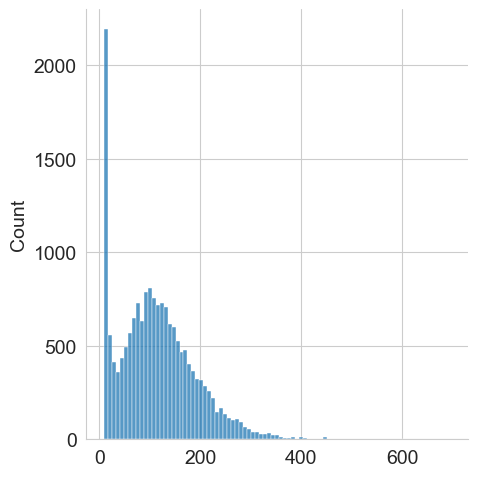

In [9]:
_ = sns.displot([len(sent) for sent in train_data])

In [7]:
vocab = build_vocab_from_iterator(train_data, specials=["<unk>"], min_freq=MIN_WORD_FREQUENCY)
vocab.set_default_index(vocab["<unk>"])

VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

Vocab size: 8076


In [7]:
train_data[102]

['seaside', 'holiday', 'j', '.', 'salmon', ',', '1918', ',', '1921']

In [8]:
vocab(train_data[102])

[0, 3041, 1415, 3, 4855, 2, 2079, 2, 3157]

In [11]:
def collate_fn(batch):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = vocab(text)

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [11]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, 
                          pin_memory=True, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                          pin_memory=True, collate_fn=collate_fn)

In [10]:
from IPython.display import clear_output
from tqdm import tqdm


def plot_losses(train_losses, valid_losses):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='valid', color='springgreen', linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, num_batches = 0.0, 1
    model.train()
    for inputs, outputs in tqdm(train_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, outputs)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1

    train_loss /= num_batches
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss, num_batches = 0.0, 0
    model.eval()
    for inputs, outputs in tqdm(valid_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        logits = model(inputs)
        loss = criterion(logits, outputs)

        valid_loss += loss.item()
        num_batches += 1

    valid_loss /= num_batches
    return valid_loss


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    train_losses, valid_losses = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses)

In [14]:
class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()
        self.embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim,
                                   max_norm=embed_max_norm)
        self.decoder = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, tokens):
        embeds = self.embeds(tokens)
        logits = self.decoder(embeds)
        return logits

In [14]:
model = Word2VecModel(embed_dim=EMBED_DIM, embed_max_norm=EMBED_MAX_NORM,
                      vocab_size=VOCAB_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

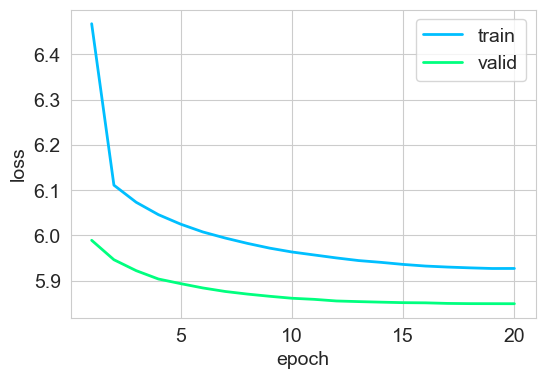

In [23]:
train(model, optimizer, scheduler, criterion, train_loader, valid_loader, NUM_EPOCHS)

In [8]:
import re


def get_similarities(embed_vector):
    similarities = embed_matrix @ embed_vector / embed_norms / torch.norm(embed_vector)
    top_indices = similarities.argsort(descending=True)
    return similarities, top_indices


def get_similar(query, num_similar=5):
    print(f'Processing query \"{query}\"')
    split_query = re.split('([^a-zA-Z0-9])', query)
    index = vocab[split_query[0]]
    embed_vector = torch.clone(embed_matrix[index])
    if index > 0:
        print(f'Found word \"{split_query[0]}\" in vocab')
    else:
        print(f'Word \"{split_query[0]}\" not in vocab, using <unk>')

    for i in range(2, len(split_query), 2):
        index = vocab[split_query[i]]
        if index > 0:
            print(f'Found word \"{split_query[i]}\" in vocab, ', end='')
        else:
            print(f'Word \"{split_query[i]}\" not in vocab, using <unk>, ', end='')
        print(f'operation \"{split_query[i - 1]}\"')

        if split_query[i - 1] == '+':
            embed_vector += embed_matrix[index]
        elif split_query[i - 1] == '-':
            embed_vector -= embed_matrix[index]
        else:
            raise ValueError('Unknown operation')

    similarities, top_indices = get_similarities(embed_vector)
    itos = vocab.get_itos()
    print('Top similar:')
    for top_index in top_indices[:num_similar]:
        print(f'    {itos[top_index]}: sim = {similarities[top_index]:.4f}')

In [26]:
embed_matrix = model.embeds.weight.detach()
embed_norms = (embed_matrix ** 2).sum(1).sqrt()

In [28]:
get_similar('woman')

Processing query "woman"
Found word "woman" in vocab
Top similar:
    woman: sim = 1.0000
    girl: sim = 0.8052
    man: sim = 0.7537
    lover: sim = 0.7271
    jealous: sim = 0.7245


In [29]:
get_similar('kick')

Processing query "kick"
Found word "kick" in vocab
Top similar:
    kick: sim = 1.0000
    touchdown: sim = 0.8505
    ecu: sim = 0.8439
    punt: sim = 0.8219
    yard: sim = 0.7997


In [32]:
get_similar('help')

Processing query "help"
Found word "help" in vocab
Top similar:
    help: sim = 1.0000
    keep: sim = 0.6878
    try: sim = 0.6757
    accept: sim = 0.6722
    bring: sim = 0.6704


In [33]:
v = get_similar('king-man+woman', num_similar=10)

Processing query "king-man+woman"
Found word "king" in vocab
Found word "man" in vocab, operation "-"
Found word "woman" in vocab, operation "+"
Top similar:
    king: sim = 0.8170
    lord: sim = 0.7112
    hairan: sim = 0.7016
    son: sim = 0.6987
    henry: sim = 0.6918
    eldest: sim = 0.6843
    edward: sim = 0.6740
    heir: sim = 0.6671
    isesi: sim = 0.6523
    daughter: sim = 0.6501


# FastText for sentiment classification

In [ ]:
%%bash
kaggle datasets download -d shivkumarganesh/bumble-dating-app-google-play-store-review
unzip bumble-dating-app-google-play-store-review.zip

In [14]:
import pandas as pd
import fasttext
import fasttext.util

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [15]:
data = pd.read_csv('bumble_google_play_reviews.csv')
data = data[data.content.notna()]
data

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8c0445eb-c4cd-4be4-8837-752a19d7f3c9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Junk. Just an ego stroker for girls who have n...,1,0,5.161.1,2023-06-11 00:34:46,Thank you for your review. We have acknowledge...,2020-10-15 09:31:24,5.161.1
1,ca5c2da8-f6e2-4825-8cef-4365251e12a1,Iris Ellington,https://play-lh.googleusercontent.com/a-/AD_cM...,I would have so many matches but I can't cuz I...,1,0,5.321.0,2023-06-10 23:49:50,NaN,NaN,5.321.0
2,ca5eed4b-2087-4d8e-918e-6c6c42d0e5aa,Eliza Lund,https://play-lh.googleusercontent.com/a-/AD_cM...,I wish the app and website allowed hyperlinkin...,2,0,5.321.0,2023-06-10 23:47:31,NaN,NaN,5.321.0
3,35538991-b115-4a87-8654-2fad67c68f01,Pt G,https://play-lh.googleusercontent.com/a/AAcHTt...,It's not free,1,0,NaN,2023-06-10 23:45:08,NaN,NaN,NaN
4,1efba490-792b-476c-a706-310216698b8f,Gaia Images,https://play-lh.googleusercontent.com/a-/AD_cM...,I set my profile up as male searching for a fe...,1,0,5.321.0,2023-06-10 23:39:24,NaN,NaN,5.321.0
...,...,...,...,...,...,...,...,...,...,...,...
131726,61bc7cdc-3085-4631-ac95-d8e42e2e0742,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Finally here!,5,54,1.0.1,2015-12-01 02:17:24,NaN,NaN,1.0.1
131727,24d07489-88ad-496a-80ce-8f137c130323,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Finally!,5,75,1.0.1,2015-12-01 02:09:05,NaN,NaN,1.0.1
131728,22a42d0d-7a12-400d-a2af-826f35d21581,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Finally, an app where women have to start the ...",4,2,1.0.1,2015-12-01 00:18:53,NaN,NaN,1.0.1
131729,2480a41f-8863-4948-9f83-7d856bd9dc78,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,At last we have Android version!,5,60,1.0.0,2015-11-30 21:27:51,NaN,NaN,1.0.0


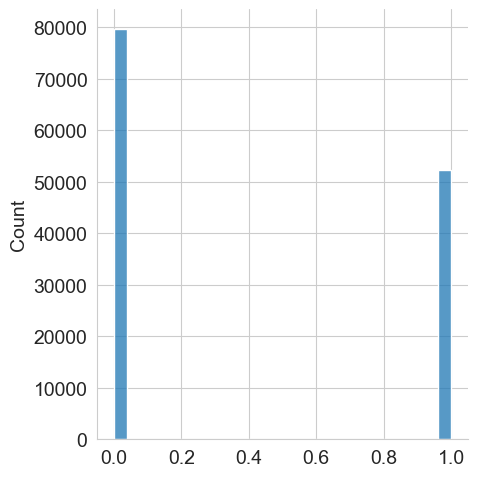

In [16]:
X = data.content.apply(tokenizer).to_list()
y = (data.score >= 4).to_numpy().astype(int)
_ = sns.displot(y)

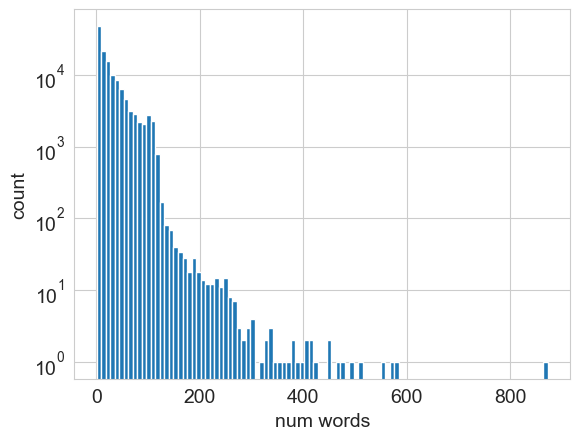

In [17]:
plt.hist([len(sent) for sent in X], bins=100)
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('num words')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_test)

(98787, 32930)

In [19]:
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [20]:
ft.get_word_vector('mother').shape

(300,)

In [21]:
ft.get_nearest_neighbors('mother')

[(0.8316885828971863, 'father'),
 (0.8139842748641968, 'grandmother'),
 (0.8042423725128174, 'daughter'),
 (0.7595430612564087, 'aunt'),
 (0.7551708221435547, 'stepfather'),
 (0.7433159947395325, 'mom'),
 (0.7390366792678833, 'step-father'),
 (0.7379246950149536, 'stepmother'),
 (0.7268661856651306, 'step-mother'),
 (0.7265076041221619, 'sister')]

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [23]:
X_train_sents = [' '.join(sent) for sent in X_train]
X_test_sents = [' '.join(sent) for sent in X_test]

In [24]:
tf_idf = TfidfVectorizer(min_df=5).fit(X_train_sents)
tf_idf_train = tf_idf.transform(X_train_sents)
tf_idf_test = tf_idf.transform(X_test_sents)

tf_idf_train.shape, tf_idf_test.shape

((98787, 8069), (32930, 8069))

In [25]:
lr = LogisticRegression(max_iter=1000).fit(tf_idf_train, y_train)

In [26]:
print(f'Tf-idf + LogRegr train acc: {accuracy_score(lr.predict(tf_idf_train), y_train):.4f}')
print(f'Tf-idf + LogRegr test acc: {accuracy_score(lr.predict(tf_idf_test), y_test):.4f}')

Tf-idf + LogRegr train acc: 0.8978
Tf-idf + LogRegr test acc: 0.8860


In [27]:
def get_sentence_embedding(sent):
    embeds = []
    for word in sent:
        embeds += [ft.get_word_vector(word)]

    return np.stack(embeds, axis=0).mean(0)

In [28]:
train_embeds = np.stack([get_sentence_embedding(sent) for sent in X_train], axis=0)
test_embeds = np.stack([get_sentence_embedding(sent) for sent in X_test], axis=0)

In [29]:
lr = LogisticRegression(max_iter=1000).fit(train_embeds, y_train)

In [30]:
print(f'FastText + LogRegr train acc: {accuracy_score(lr.predict(train_embeds), y_train):.4f}')
print(f'FastText + LogRegr test acc: {accuracy_score(lr.predict(test_embeds), y_test):.4f}')

FastText + LogRegr train acc: 0.8571
FastText + LogRegr test acc: 0.8555


In [31]:
BATCH_SIZE = 128
MAX_SEQUENCE_LENGTH = 256
MODEL_BLOCKS = 2
MODEL_CHANNELS = 300
NUM_EPOCHS = 5

In [32]:
class EmbeddingsDataset(Dataset):
    def __init__(self, sents, targets, max_length):
        super().__init__()
        self.max_length = max_length
        self.sents = sents
        self.targets = targets
    
    def __len__(self):
        return len(self.sents)

    def __getitem__(self, item):
        sent = self.sents[item]
        length = min(len(sent), self.max_length)

        embeds = []
        for word in sent[:length]:
            embeds += [torch.from_numpy(ft.get_word_vector(word).astype(np.float32))]
        
        embeds = torch.stack(embeds, dim=1)
        padding = torch.zeros((embeds.shape[0], self.max_length - length))
        embeds = torch.cat([embeds, padding], dim=1)
        target = self.targets[item]
        return embeds, length, target

In [33]:
train_set = EmbeddingsDataset(X_train, y_train, max_length=MAX_SEQUENCE_LENGTH)
test_set = EmbeddingsDataset(X_test, y_test, max_length=MAX_SEQUENCE_LENGTH)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=4,
                          pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=4,
                         pin_memory=True)

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [35]:
class BasicBlock(nn.Module):
    def __init__(self, num_channels, kernel_size):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_channels)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out + x)
        return out

class TextCNN(nn.Module):
    def __init__(self, num_blocks, num_channels, num_classes, kernel_size=5):
        super().__init__()
        self.backbone = nn.Sequential(
            *[BasicBlock(num_channels, kernel_size) for _ in range(num_blocks)]
        )

        self.classifier = nn.Linear(num_channels, num_classes)

    @staticmethod
    def get_lengths_mask(embeds, lengths):
        mask = torch.arange(embeds.shape[-1]).unsqueeze(0).to(embeds.device)
        mask = (mask < lengths.unsqueeze(1)).to(torch.float)
        return mask.unsqueeze(1)

    def forward(self, embeds, lengths):
        # embeds: (B, C, T), lengths: (B, )
        features = self.backbone(embeds)
        # features: (B, C, T)
        mask = self.get_lengths_mask(embeds, lengths)
        # mask: (B, 1, T)
        features = (features * mask).sum(-1) / lengths.unsqueeze(1)
        # features: (B, C)
        logits = self.classifier(features)
        # logits: (B, num_classes)
        return logits

In [36]:
from IPython.display import clear_output
from tqdm.notebook import tqdm


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train',
                color='deepskyblue', linewidth=2)
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [37]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for embeds, lengths, labels in tqdm(train_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)
        embeds = embeds[..., :lengths.max()]

        optimizer.zero_grad()
        logits = model(embeds, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]
        train_accuracy += (logits.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss, valid_accuracy = 0.0, 0.0
    model.eval()
    for embeds, lengths, labels in tqdm(valid_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)
        embeds = embeds[..., :lengths.max()]

        logits = model(embeds, lengths)
        loss = criterion(logits, labels)

        valid_loss += loss.item() * embeds.shape[0]
        valid_accuracy += (logits.argmax(1) == labels).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy /= len(valid_loader.dataset)
    return valid_loss, valid_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss, valid_accuracy = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        valid_losses += [valid_loss]
        valid_accuracies += [valid_accuracy]
        plot_losses(train_losses, valid_losses, train_accuracies, valid_accuracies)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [38]:
model = TextCNN(num_blocks=MODEL_BLOCKS, num_channels=MODEL_CHANNELS, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

In [39]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader, NUM_EPOCHS)

Training 1/5:   0%|          | 0/772 [00:00<?, ?it/s]